# Service 1

In [1]:
import pandas as pd

data = pd.read_csv('Service1.csv', parse_dates=['timestamp'])

# Preview Data
data.head()

,timestamp,cpu_allocated,memory_allocated,cpu_usage_pct,memory_usage_pct,latency_ms
0,2025-05-03 15:49:34.233160,1.0,2048.00,0.25,0.0,51.62
1,2025-05-03 15:50:34.233160,1.0,2047.82,0.25,0.0,83.61
2,2025-05-03 15:51:34.233160,1.0,2047.64,0.25,0.0,67.56
3,2025-05-03 15:52:34.233160,1.0,2047.46,0.25,0.0,81.58
4,2025-05-03 15:53:34.233160,1.0,2047.28,0.25,0.0,75.77


## Plot Latency vs CPU Usage

Text(0.5, 1.0, 'Latency vs CPU Usage')

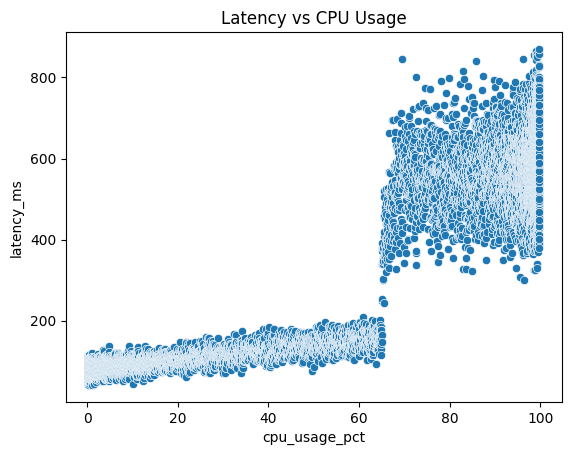

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data, x="cpu_usage_pct", y = "latency_ms")
plt.title("Latency vs CPU Usage")

## Plot Latency vs Memory Usage

Text(0.5, 1.0, 'Latency vs Memory Usage')

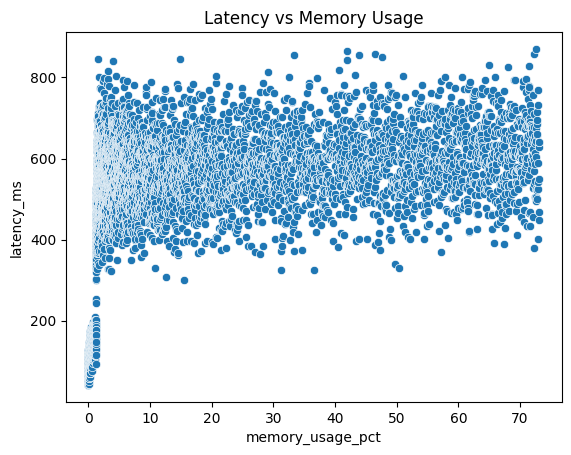

In [5]:
sns.scatterplot(data=data, x="memory_usage_pct", y = "latency_ms")
plt.title("Latency vs Memory Usage")

## Latency Over Time + CPU/Memory Overlay

Text(0.5, 1.0, 'Latency & CPU Usage Over Time')

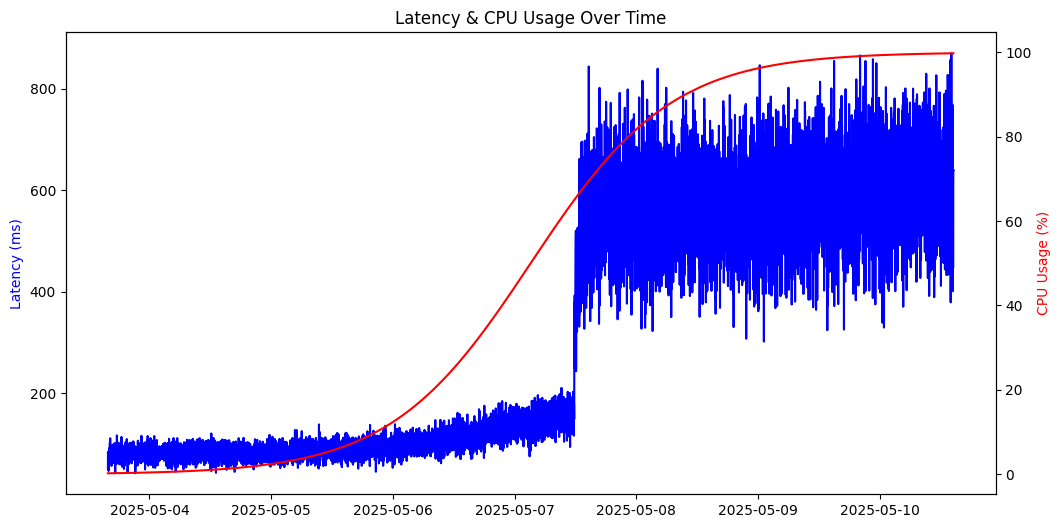

In [8]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Latency plot
ax1.plot(data['timestamp'], data["latency_ms"], label="latency", color = "blue")
ax1.set_ylabel('Latency (ms)', color = 'blue')

# Add CPU usage on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(data["timestamp"], data['cpu_usage_pct'], label = 'CPU Usage', color = 'red')
ax2.set_ylabel('CPU Usage (%)', color = 'red')

plt.title('Latency & CPU Usage Over Time')

## Lag Analysis Before Spikes (Latency as Target)

Text(0.5, 1.0, 'Latency vs CPU Usage 5 intervals earlier')

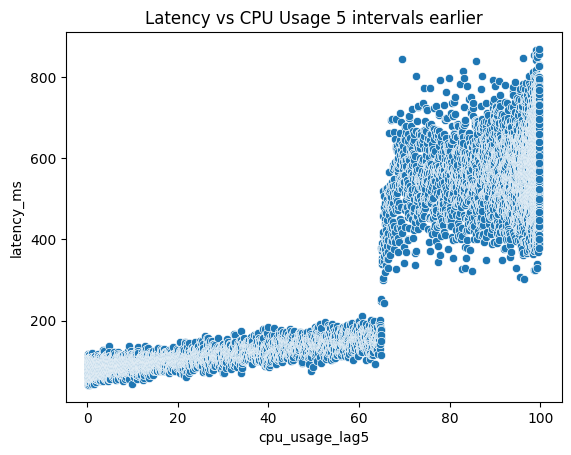

In [9]:
data['cpu_usage_lag5'] = data['cpu_usage_pct'].shift(5)
data['memory_usage_lag5'] = data['memory_usage_pct'].shift(5)

sns.scatterplot(data=data, x='cpu_usage_lag5', y='latency_ms')
plt.title("Latency vs CPU Usage 5 intervals earlier")


## Detect Spike Windows

In [11]:
import numpy as np

# Define a spike
data['latency_diff'] = data['latency_ms'].diff()
data['is_spike'] = data['latency_diff'] > data['latency_ms'].mean()

# Plot spike triggers
spike_windows = data[data['is_spike']]

# Plot CPU/Memory around spike times
for i, row in spike_windows.iterrows():
    print(f"Spike at {row['timestamp']} | CPU: {row['cpu_usage_pct']} | Mem: {row['memory_usage_pct']}")


Spike at 2025-05-07 14:36:34.233160 | CPU: 69.53 | Mem: 1.51
Spike at 2025-05-07 16:43:34.233160 | CPU: 72.66 | Mem: 1.76
Spike at 2025-05-07 21:24:34.233160 | CPU: 78.83 | Mem: 2.45
Spike at 2025-05-08 01:00:34.233160 | CPU: 82.83 | Mem: 3.15
Spike at 2025-05-08 02:06:34.233160 | CPU: 83.93 | Mem: 3.4
Spike at 2025-05-08 05:37:34.233160 | CPU: 87.06 | Mem: 4.34
Spike at 2025-05-08 05:52:34.233160 | CPU: 87.26 | Mem: 4.41
Spike at 2025-05-08 06:52:34.233160 | CPU: 88.04 | Mem: 4.73
Spike at 2025-05-08 10:33:34.233160 | CPU: 90.56 | Mem: 6.07
Spike at 2025-05-08 11:30:34.233160 | CPU: 91.13 | Mem: 6.48
Spike at 2025-05-08 21:39:34.233160 | CPU: 95.53 | Mem: 12.57
Spike at 2025-05-09 00:02:34.233160 | CPU: 96.2 | Mem: 14.59
Spike at 2025-05-09 01:08:34.233160 | CPU: 96.48 | Mem: 15.6
Spike at 2025-05-09 11:25:34.233160 | CPU: 98.29 | Mem: 27.93
Spike at 2025-05-09 12:11:34.233160 | CPU: 98.38 | Mem: 29.06
Spike at 2025-05-09 14:57:34.233160 | CPU: 98.67 | Mem: 33.33
Spike at 2025-05-09 1

## Find Safe Allocation Bounds

In [13]:
high_latency = data[data['latency_ms'] > data['latency_ms'].mean()]

# CPU/memory levels during spikes
print("Typical CPU during spikes:", high_latency['cpu_usage_pct'].describe())
print("Typical Memory during spikes:", high_latency['memory_usage_pct'].describe())


Typical CPU during spikes: count    4477.000000
mean       92.070456
std         9.278109
min        65.020000
25%        87.750000
50%        96.490000
75%        99.060000
max        99.750000
Name: cpu_usage_pct, dtype: float64
Typical Memory during spikes: count    4477.000000
mean       24.211229
std        22.313298
min         1.240000
25%         4.600000
50%        15.630000
75%        41.510000
max        73.110000
Name: memory_usage_pct, dtype: float64


### Compare With The Normal Case

In [15]:
low_latency = data[data['latency_ms'] <= data['latency_ms'].mean()]
print("CPU safe range:", low_latency['cpu_usage_pct'].quantile([0.1, 0.9]))
print("Memory safe range:", low_latency['memory_usage_pct'].quantile([0.1, 0.9]))

CPU safe range: 0.1     0.480
0.9    49.114
Name: cpu_usage_pct, dtype: float64
Memory safe range: 0.1    0.00
0.9    0.65
Name: memory_usage_pct, dtype: float64
